### Import useful packages

In [ ]:
!pip install skorch==0.11.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars

#import plotly_express as px #plotly_express = "0.4.0"
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
import copy
import itertools
from sklearn import manifold
import plotly.express as px
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F

import skorch
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV

def load_data(plot_samples = True): ### Download the data and create dataset
  data_dir = 'dataset'
  train_dataset = torchvision.datasets.FashionMNIST(data_dir, train=True, download=True)
  test_dataset  = torchvision.datasets.FashionMNIST(data_dir, train=False, download=True)

  data = {
      "train_dataset": train_dataset,
      "test_dataset": test_dataset
  }

  if (plot_samples):
      ### Plot some sample
      label_names=['t-shirt','trouser','pullover','dress','coat','sandal','shirt',
                  'sneaker','bag','boot']
      fig, axs = plt.subplots(5, 5, figsize=(8,8))
      for ax in axs.flatten():
          # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
          img, label = random.choice(train_dataset)
          ax.imshow(np.array(img), cmap='gist_gray')
          ax.set_title(f'Label: {label_names[label]} [{label}]')
          ax.set_xticks([])
          ax.set_yticks([])
      plt.tight_layout()

  return data

def plot(df, plot_label, title=None):
    plt.figure(figsize=(12,8))
    plt.scatter(df.input, df.label, label=plot_label)
    plt.xlabel('input')
    plt.ylabel('label')
    if (title is not None):
        plt.title(title)
    plt.legend()
    plt.show()

def plot_loss(train_loss_log, val_loss_log):
  # Plot losses of the best model
  plt.figure(figsize=(12,8))
  plt.semilogy(train_loss_log, label='Train loss')
  plt.semilogy(val_loss_log, label='Validation loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.grid()
  plt.legend()
  plt.show()

def gaussian_noise(image, noise_factor = 0.1*3):
    noisy_img = image + noise_factor * torch.randn(image.shape)
    noisy_img = np.clip(noisy_img, 0., 1.)
    
    return noisy_img

class ApplyNoiseTransform(object):
    @staticmethod
    def apply_transformations(data):
      train_transform = transforms.Compose([
          transforms.ToTensor(),
          ApplyNoiseTransform(),
      ])

      test_transform = transforms.Compose([
          transforms.ToTensor(),
          ApplyNoiseTransform(),
      ])
      
      data['train_transform'] = train_transform
      data['test_transform'] = test_transform

      data['train_dataset'].transform = train_transform
      data['test_dataset'].transform = test_transform

    def __call__(self, image):
        noisy_img = gaussian_noise(image)
        return (image, noisy_img)


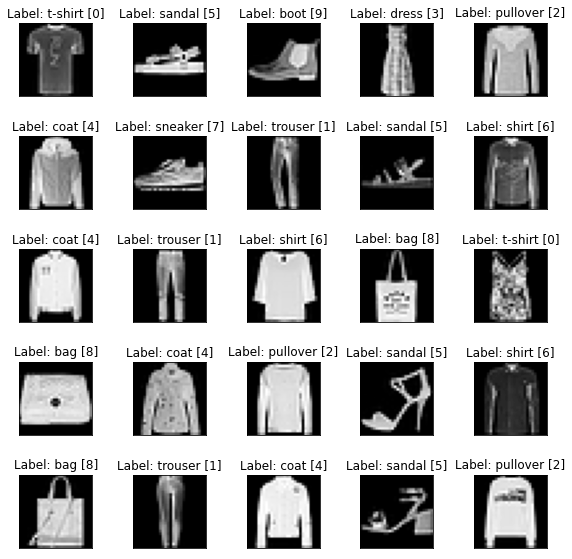

In [ ]:
data = load_data()

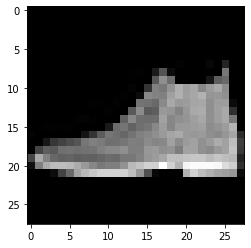

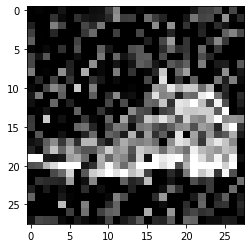

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 256

data['device'] = device

ApplyNoiseTransform.apply_transformations(data)

data['train_dataloader'] = DataLoader(data['train_dataset'], batch_size = batch_size, shuffle = True)
data['test_dataloader'] = DataLoader(data['test_dataset'], batch_size = len(data['test_dataset']), shuffle = False)

# validating dataloader with noise applied to images
iterator = iter(data['test_dataloader'])
image = iterator.next()
plt.imshow(image[0][0][0][0],cmap='gray')
plt.show()
plt.imshow(image[0][1][0][0],cmap='gray')
plt.show()

# Encoder and Decoder Models

In [ ]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,dropout=0.2, conv1=8,conv2=16,conv3=32,fc=64):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(1, conv1, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Dropout2d(p=dropout),
            # Second convolutional layer
            nn.Conv2d(conv1, conv2, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Dropout2d(p=dropout),
            # Third convolutional layer
            nn.Conv2d(conv2, conv3, 3, stride=2, padding=0),
            nn.ReLU(True),
            nn.Dropout2d(p=dropout),
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)#dimension 0 is the sample, so we flatten from dimension 1

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(3 * 3 * conv3, fc),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
            # Second linear layer
            nn.Linear(fc, encoded_space_dim)
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.encoder_lin(x)
        return x


class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,dropout=0.5, conv1=8,conv2=16,conv3=32,fc=64):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(encoded_space_dim, fc),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
            # Second linear layer
            nn.Linear(fc, 3 * 3 * conv3),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(conv3, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(conv3, conv2, 3, stride=2, output_padding=0),
            nn.ReLU(True),
            nn.Dropout2d(p=dropout),
            # Second transposed convolution
            nn.ConvTranspose2d(conv2, conv1, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.Dropout2d(p=dropout),
            # Third transposed convolution
            nn.ConvTranspose2d(conv1, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x
  
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer, should_apply_noise = False):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        
        original_image = image_batch[0].to(device)
        noisy_image = image_batch[1].to(device) if should_apply_noise else original_image    

        # Encode data
        encoded_data = encoder(noisy_image)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, original_image)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        #print('\t partial train loss (single batch): %f' % (loss.data))
    return loss.data


### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn, should_apply_noise = False):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            original_image = image_batch[0].to(device)
            noisy_image = image_batch[1].to(device) if should_apply_noise else original_image    
                
            # Encode data
            encoded_data = encoder(noisy_image)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(original_image.cpu())

        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data
  
### Training cycle
def training_cycle(data, num_epochs, early_stopping, encoder, decoder, loss_fn, optim, train_dataloader, device, test_dataset, encoded_space_dim, should_apply_noise = False, plotAndSaveImages = False):
    train_loss_log = []
    val_loss_log = []

    max_early=float("-inf")
    idx_early=-1

    for epoch in range(num_epochs):
        #print('\t EPOCH %d/%d' % (epoch + 1, num_epochs))
        ### Training (use the training function)
        train_loss=train_epoch(
            encoder=encoder, 
            decoder=decoder, 
            device=device, 
            dataloader=data['train_dataloader'], 
            loss_fn=loss_fn, 
            optimizer=optim,
            should_apply_noise=should_apply_noise)
        train_loss_log.append(train_loss)
        print('\t TRAIN - EPOCH %d/%d - loss: %f' % (epoch + 1, num_epochs, train_loss))

        ### Validation  (use the testing function)
        val_loss = test_epoch(
            encoder=encoder, 
            decoder=decoder, 
            device=device, 
            dataloader=data['test_dataloader'], 
            loss_fn=loss_fn,
            should_apply_noise=should_apply_noise)
        val_loss_log.append(val_loss)
        print('\t VALIDATION - EPOCH %d/%d - loss: %f' % (epoch + 1, num_epochs, val_loss))

        ### Plot progress
        # Get the output of a specific image (the test image at index 0 in this case)
        img = test_dataset[0][0][0].unsqueeze(0).to(device)
        if should_apply_noise: img = test_dataset[0][0][1].unsqueeze(0).to(device)
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            rec_img  = decoder(encoder(img))
        if (plotAndSaveImages):
          # Plot the reconstructed image
          fig, axs = plt.subplots(1, 2, figsize=(12,6))
          axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
          axs[0].set_title('Original image')
          axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
          axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
          plt.tight_layout()
          plt.pause(0.1)
          # Save figures
          os.makedirs('autoencoder_progress_%d_features' % encoded_space_dim, exist_ok=True)
          fig.savefig('autoencoder_progress_%d_features/epoch_%d.jpg' % (encoded_space_dim, epoch + 1))
          plt.show()
          plt.close()

          # Save network parameters
          torch.save(encoder.state_dict(), 'encoder_params.pth')
          torch.save(decoder.state_dict(), 'decoder_params.pth')
          torch.save(optim.state_dict(), 'optim_params.pth')


        #Early stopping:
        if idx_early==-1:
            idx_early=epoch
            max_early=val_loss
        elif round(float(val_loss), 3) < round(float(max_early), 3):
            idx_early=epoch
            max_early=val_loss

        elif epoch - idx_early >= early_stopping: # if is not improving for 'early_stopping' epochs, then stop
            print(f"STOPPED BY EARLY STOPPING - No improvements after {early_stopping} epochs.")
            break
    
    return (train_loss_log, val_loss_log)

def single_train(data, params, plotAndSaveImages = False, should_apply_noise = False):
  num_epochs =      data['params']['num_epochs'] #50
  early_stopping =  data['params']['early_stopping'] #5
  drop =            data['params']['dropout'] #0
  loss_fn = data['params']['loss_fn']
  encoded_space_dim, conv1, conv2, conv3, fc, lr, l2 = params
          
  ### Initialize the two networks
  encoder = Encoder(encoded_space_dim=encoded_space_dim,dropout=drop, conv1=conv1,conv2=conv2,conv3=conv3,fc=fc)
  decoder = Decoder(encoded_space_dim=encoded_space_dim,dropout=drop, conv1=conv1,conv2=conv2,conv3=conv3,fc=fc)

  ### Define an optimizer (both for the encoder and the decoder!)
  params_to_optimize = [
      {'params': encoder.parameters()},
      {'params': decoder.parameters()}
  ]
  optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=l2)

  # Move both the encoder and the decoder to the selected device
  encoder.to(device)
  decoder.to(device)
  
  
  #TRAINING CYCLE
  train_loss_log,val_loss_log=training_cycle(data, 
                                            num_epochs,
                                            early_stopping,
                                            encoder,
                                            decoder,
                                            loss_fn,
                                            optim,
                                            data['train_dataloader'],
                                            device,
                                            data['test_dataset'],
                                            encoded_space_dim = encoded_space_dim,
                                            should_apply_noise = should_apply_noise,
                                            plotAndSaveImages = plotAndSaveImages)
  
  return train_loss_log, val_loss_log, encoder, decoder

def tune_parameters_adam(data):
  encoded_space_dim = data['params_to_tune']['encoded_space_dim'] #[10]
  Conv1 =     data['params_to_tune']['conv1'] #[8]
  Conv2 =     data['params_to_tune']['conv2'] #[16]
  Conv3 =     data['params_to_tune']['conv3'] #[32]
  FC =        data['params_to_tune']['fc'] #[64]
  LR =        data['params_to_tune']['lr'] #[1e-3]
  L2 =        data['params_to_tune']['l2'] #[1e-5]

  num_epochs =      data['params']['num_epochs'] #50
  early_stopping =  data['params']['early_stopping'] #5
  drop =            data['params']['dropout'] #0


  hyperparams = [encoded_space_dim,Conv1,Conv2,Conv3,FC,LR,L2]  

  iterations=[]
  for hyper in itertools.product(*hyperparams):
      iterations.append(hyper)
  print("Total Combinations:",len(iterations))


  best_hyper=None
  best_loss=None
  for i,hyper in enumerate(iterations):
      #print("\n\nIteration:",i,hyper)
      print(f"\n\nIteration {i}: {hyper}")
      train_loss_log, val_loss_log, _, _ = single_train(data, hyper)
      train_loss=train_loss_log[-1]
      val_loss=val_loss_log[-1]
      print("\tTrain Loss:",round(float(train_loss),3),"\tVal Loss:",round(float(val_loss),3))
      
      if not best_loss or val_loss<best_loss:
          best_loss=val_loss
          best_hyper=hyper

          
  print("\n\nBest Model:", best_hyper)
  encoded_space_dim, conv1, conv2, conv3, fc, lr, l2 = best_hyper

  data['best_params'] = {
      'encoded_space_dim': encoded_space_dim,
      'conv1': conv1,
      'conv2': conv2,
      'conv3': conv3,
      'fc': fc,
      'lr': lr,
      'l2': l2
  }


In [ ]:
data['params'] = {
    'num_epochs': 50,
    'early_stopping': 8,
    'dropout': 0.1,
    'loss_fn': torch.nn.MSELoss() # loss function
}
data['params_to_tune'] = {
    'encoded_space_dim': [10],
    'conv1': [8, 16],
    'conv2': [16, 32],
    'conv3': [16, 32],
    'fc': [32],
    'lr': [1e-3],
    'l2': [1e-5]
}

In [ ]:
tune_parameters_adam(data)

Total Combinations: 8


Iteration 0: (10, 8, 16, 16, 32, 0.001, 1e-05)
	 TRAIN - EPOCH 1/50 - loss: 0.062669
	 VALIDATION - EPOCH 1/50 - loss: 0.060046
	 TRAIN - EPOCH 2/50 - loss: 0.049785
	 VALIDATION - EPOCH 2/50 - loss: 0.043051
	 TRAIN - EPOCH 3/50 - loss: 0.042022
	 VALIDATION - EPOCH 3/50 - loss: 0.034438
	 TRAIN - EPOCH 4/50 - loss: 0.038055
	 VALIDATION - EPOCH 4/50 - loss: 0.030897
	 TRAIN - EPOCH 5/50 - loss: 0.037109
	 VALIDATION - EPOCH 5/50 - loss: 0.028918
	 TRAIN - EPOCH 6/50 - loss: 0.035003
	 VALIDATION - EPOCH 6/50 - loss: 0.027872
	 TRAIN - EPOCH 7/50 - loss: 0.034523
	 VALIDATION - EPOCH 7/50 - loss: 0.027473
	 TRAIN - EPOCH 8/50 - loss: 0.035795
	 VALIDATION - EPOCH 8/50 - loss: 0.026762
	 TRAIN - EPOCH 9/50 - loss: 0.033330
	 VALIDATION - EPOCH 9/50 - loss: 0.026578
	 TRAIN - EPOCH 10/50 - loss: 0.032698
	 VALIDATION - EPOCH 10/50 - loss: 0.026259
	 TRAIN - EPOCH 11/50 - loss: 0.032230
	 VALIDATION - EPOCH 11/50 - loss: 0.025339
	 TRAIN - EPOCH 12/50 - loss: 0.03

#### Plotting loss of the execution with best parameters

	 TRAIN - EPOCH 1/50 - loss: 0.041449
	 VALIDATION - EPOCH 1/50 - loss: 0.036826


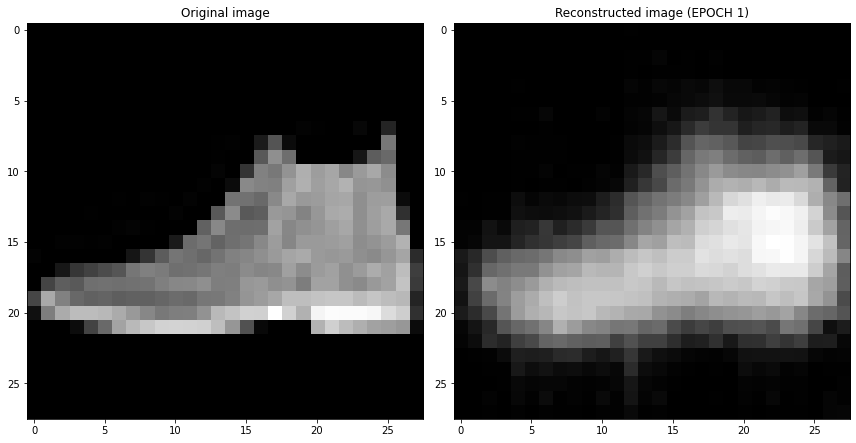

	 TRAIN - EPOCH 2/50 - loss: 0.039056
	 VALIDATION - EPOCH 2/50 - loss: 0.030303


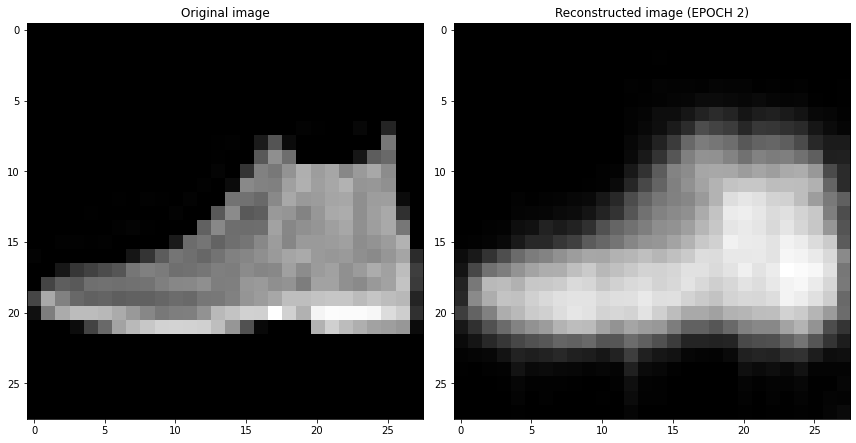

	 TRAIN - EPOCH 3/50 - loss: 0.032467
	 VALIDATION - EPOCH 3/50 - loss: 0.027643


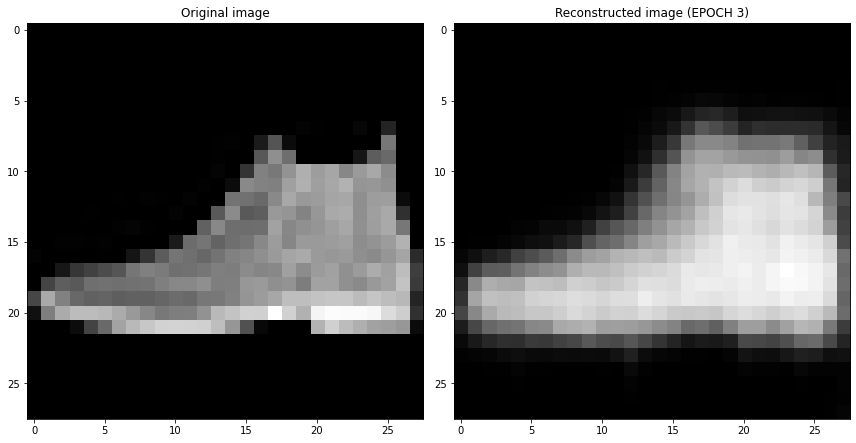

	 TRAIN - EPOCH 4/50 - loss: 0.031457
	 VALIDATION - EPOCH 4/50 - loss: 0.025954


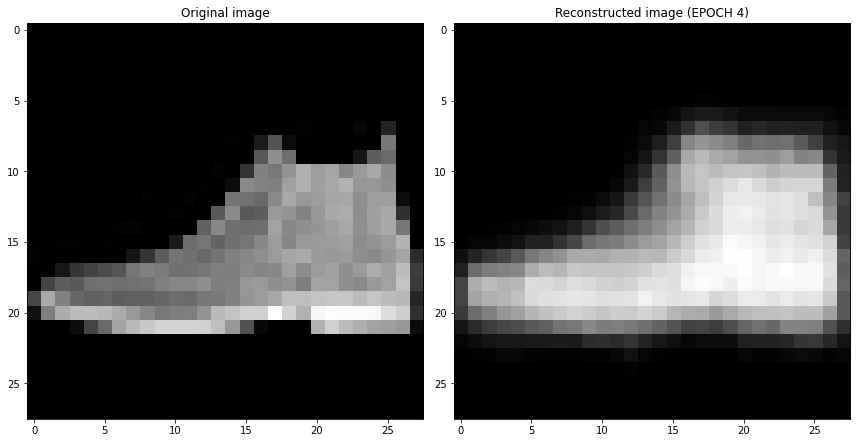

	 TRAIN - EPOCH 5/50 - loss: 0.031075
	 VALIDATION - EPOCH 5/50 - loss: 0.024744


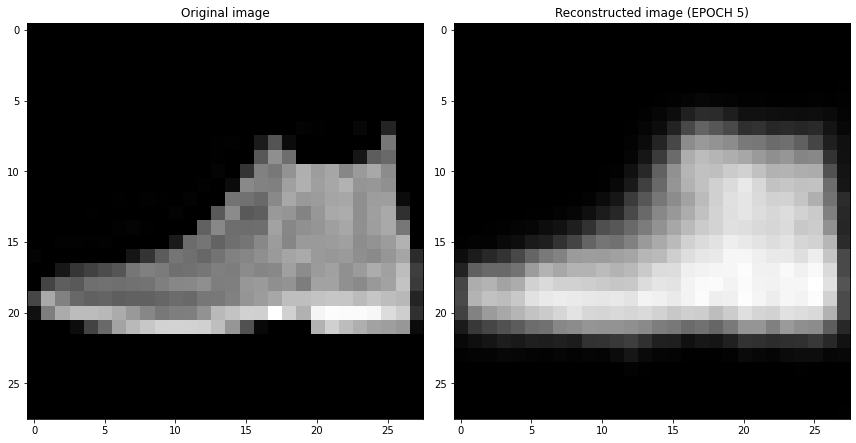

	 TRAIN - EPOCH 6/50 - loss: 0.027346
	 VALIDATION - EPOCH 6/50 - loss: 0.024038


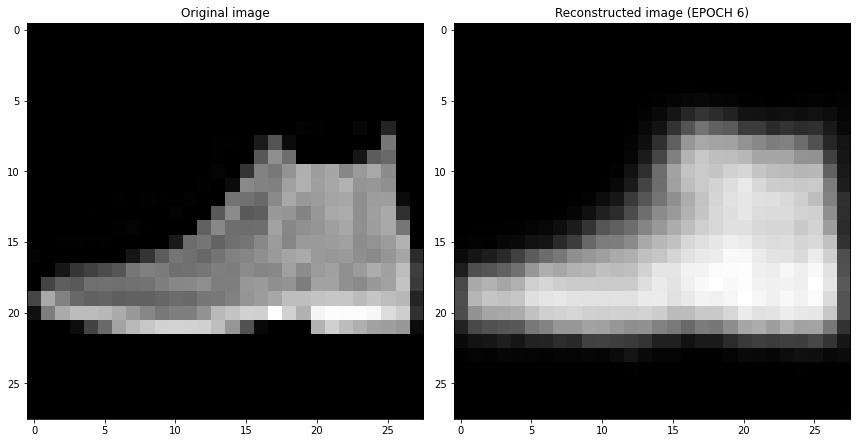

	 TRAIN - EPOCH 7/50 - loss: 0.026366
	 VALIDATION - EPOCH 7/50 - loss: 0.023302


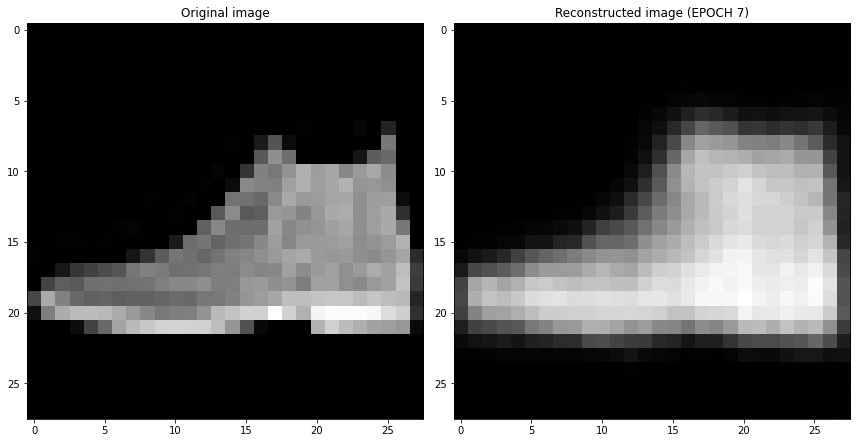

	 TRAIN - EPOCH 8/50 - loss: 0.027991
	 VALIDATION - EPOCH 8/50 - loss: 0.022855


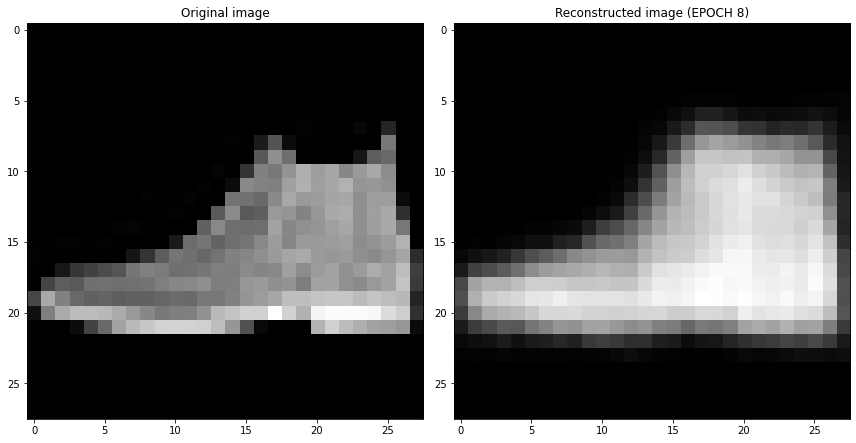

	 TRAIN - EPOCH 9/50 - loss: 0.028523
	 VALIDATION - EPOCH 9/50 - loss: 0.022224


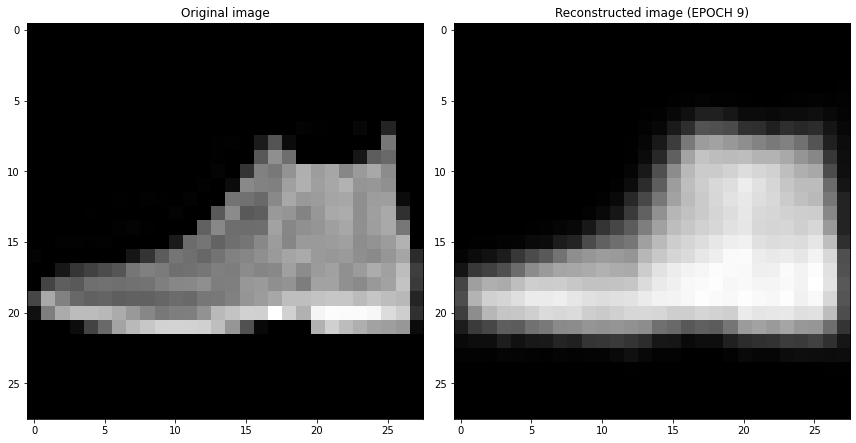

	 TRAIN - EPOCH 10/50 - loss: 0.026290
	 VALIDATION - EPOCH 10/50 - loss: 0.022123


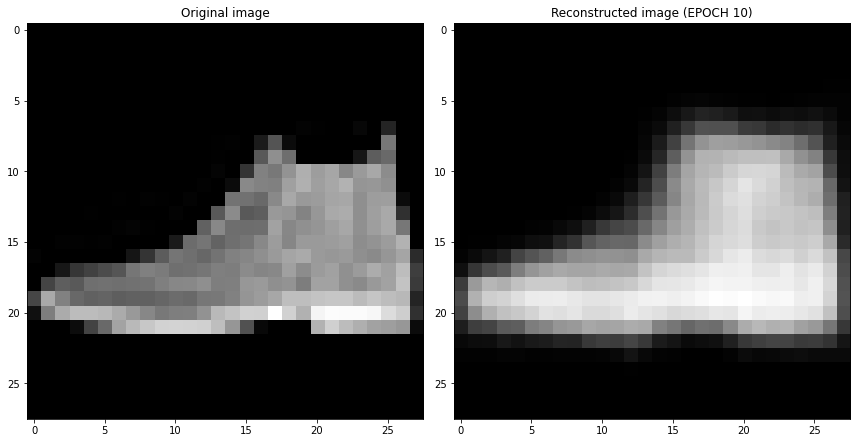

	 TRAIN - EPOCH 11/50 - loss: 0.028074
	 VALIDATION - EPOCH 11/50 - loss: 0.021947


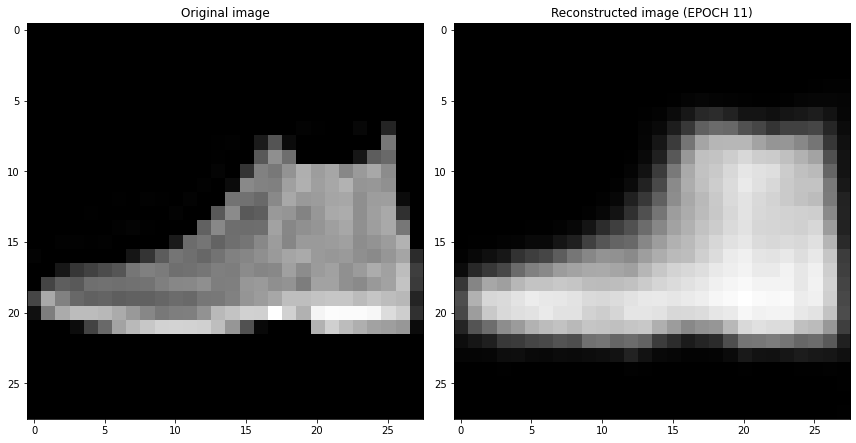

	 TRAIN - EPOCH 12/50 - loss: 0.025894
	 VALIDATION - EPOCH 12/50 - loss: 0.021497


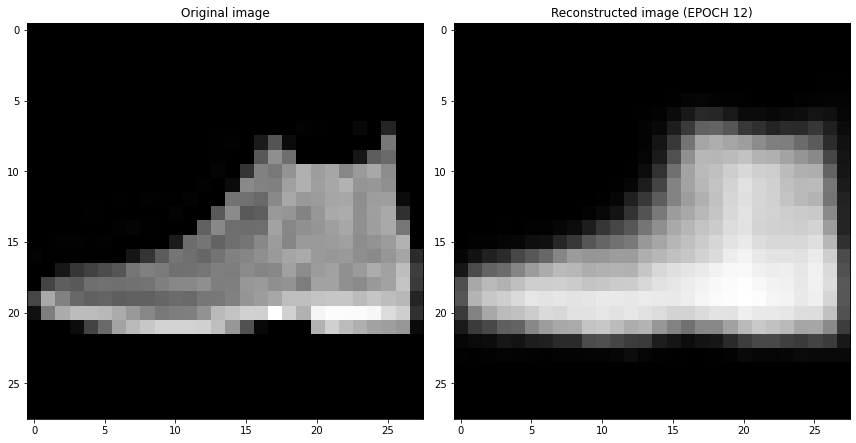

	 TRAIN - EPOCH 13/50 - loss: 0.027140
	 VALIDATION - EPOCH 13/50 - loss: 0.021334


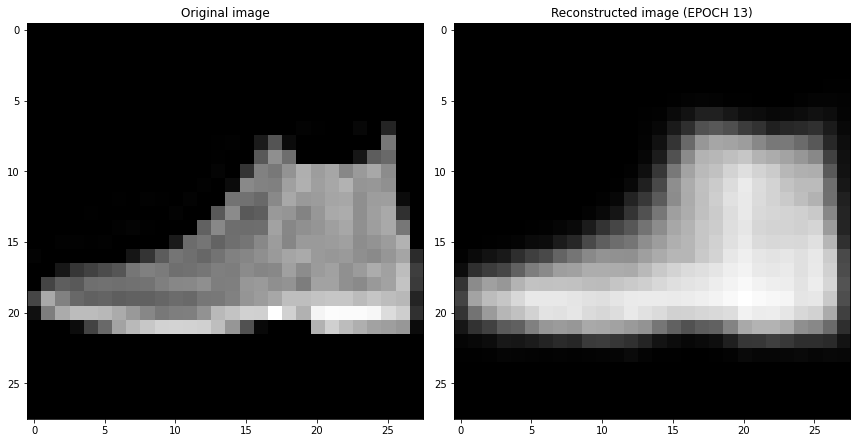

	 TRAIN - EPOCH 14/50 - loss: 0.026134
	 VALIDATION - EPOCH 14/50 - loss: 0.021174


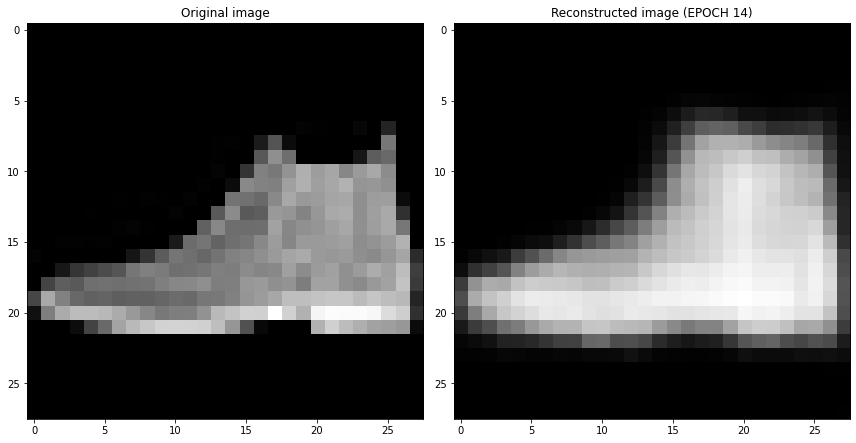

	 TRAIN - EPOCH 15/50 - loss: 0.025635
	 VALIDATION - EPOCH 15/50 - loss: 0.021141


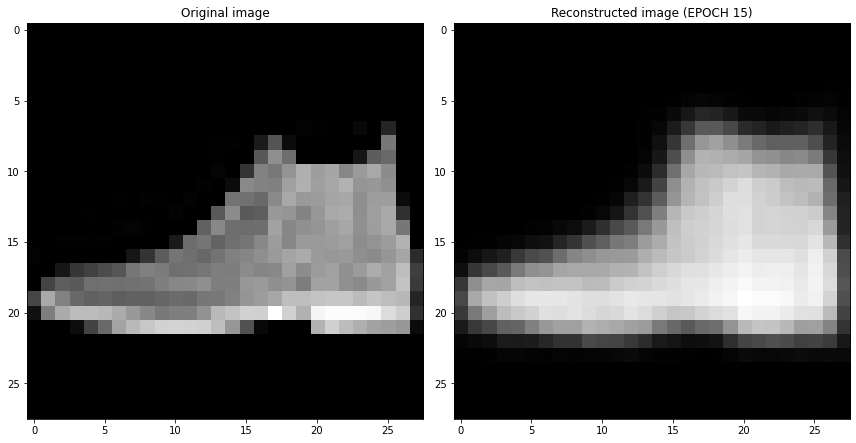

	 TRAIN - EPOCH 16/50 - loss: 0.027516
	 VALIDATION - EPOCH 16/50 - loss: 0.020918


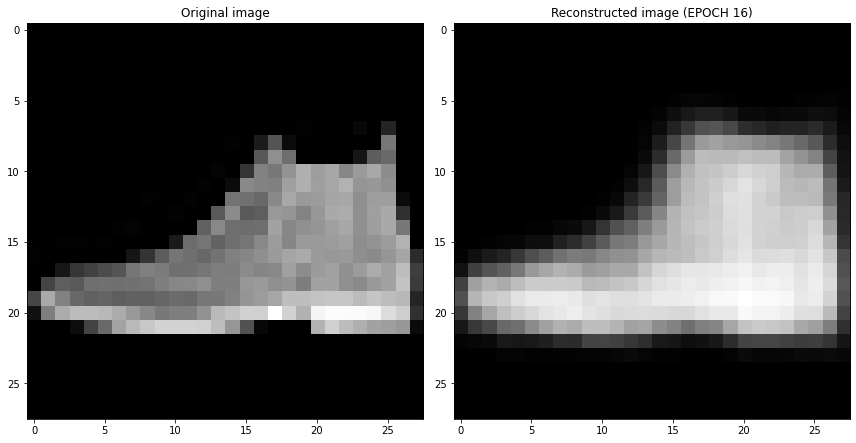

	 TRAIN - EPOCH 17/50 - loss: 0.024379
	 VALIDATION - EPOCH 17/50 - loss: 0.020878


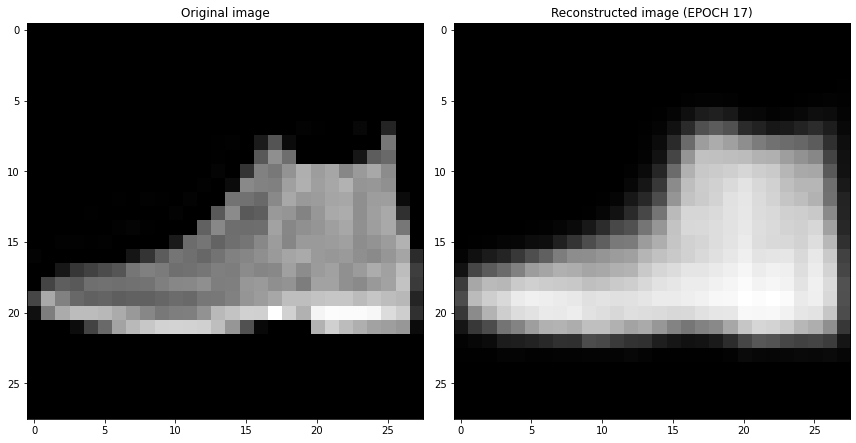

	 TRAIN - EPOCH 18/50 - loss: 0.025027
	 VALIDATION - EPOCH 18/50 - loss: 0.020873


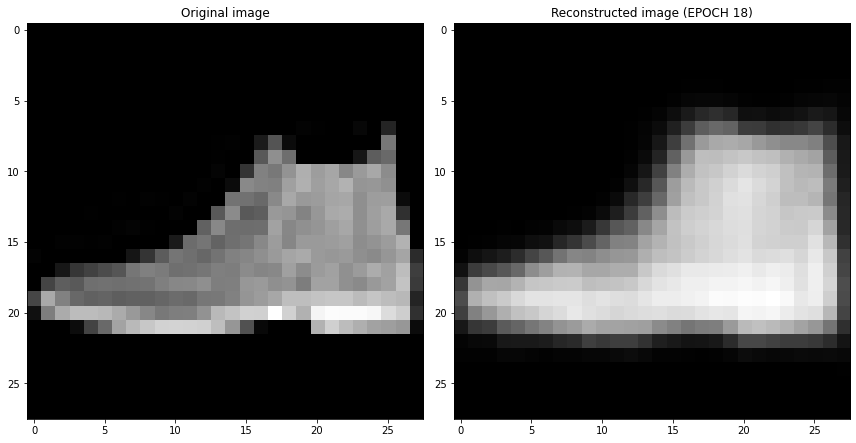

	 TRAIN - EPOCH 19/50 - loss: 0.026374
	 VALIDATION - EPOCH 19/50 - loss: 0.020797


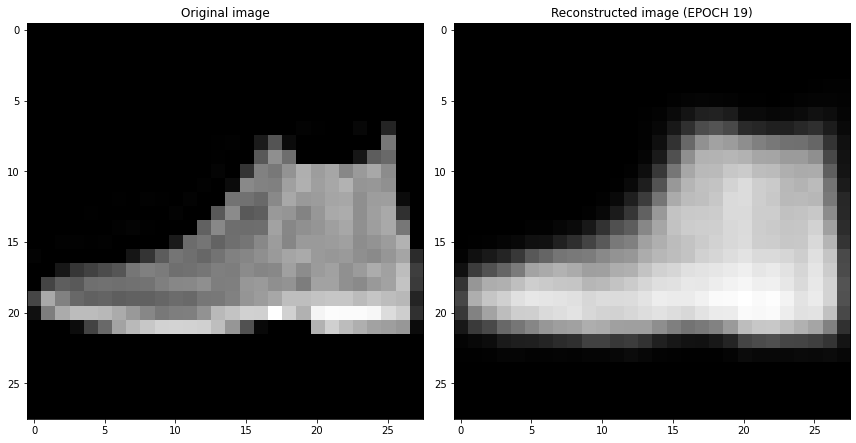

	 TRAIN - EPOCH 20/50 - loss: 0.024046
	 VALIDATION - EPOCH 20/50 - loss: 0.020614


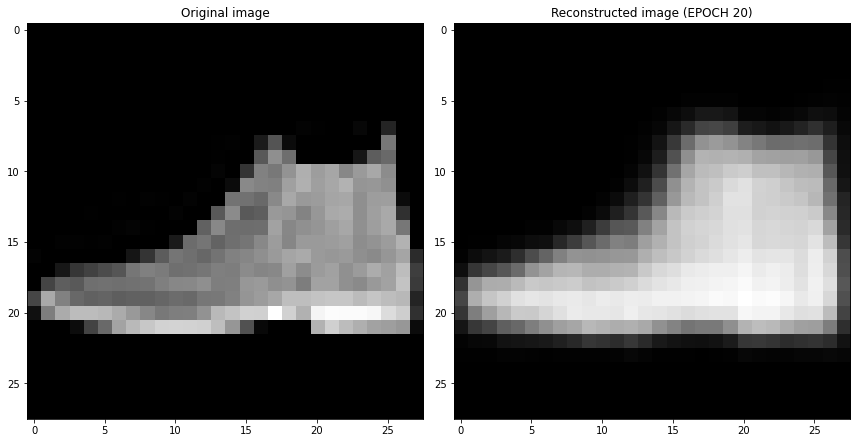

STOPPED BY EARLY STOPPING - No improvements after 8 epochs.


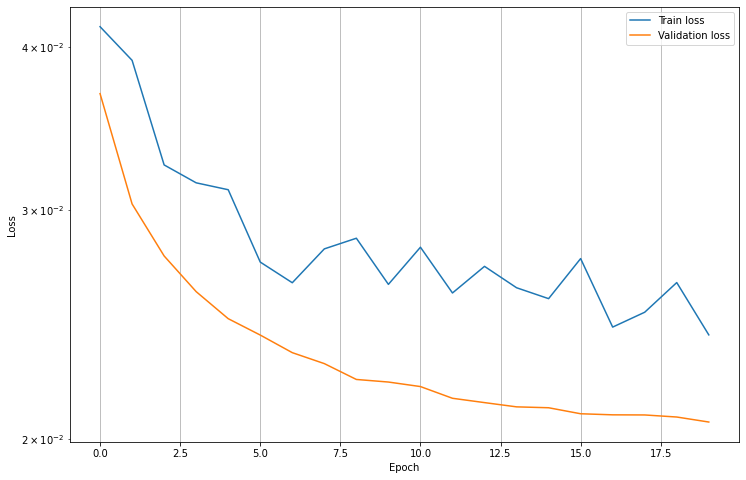

In [ ]:
# TO BE REMOVED
# TO BE REMOVED
# TO BE REMOVED
# TO BE REMOVED
# TO BE REMOVED
#data['best_params'] = {          # TO BE REMOVED
#    'encoded_space_dim': 10,
#    'conv1': 16,
#    'conv2': 32,
#    'conv3': 32,
#    'fc': 32,
#    'lr': 1e-3,
#    'l2': 1e-5
#}
######################################################

#data['params'] = {
#    'num_epochs': 50,
#    'early_stopping': 8,
#    'dropout': 0.1,
#    'loss_fn': torch.nn.MSELoss() # loss function
#}

train_loss_log, val_loss_log, encoder, decoder = single_train(data, list(data['best_params'].values()), plotAndSaveImages = True)
if torch.cuda.is_available():
  train_loss_log = [x.cpu() for x in train_loss_log]
  val_loss_log = [x.cpu() for x in val_loss_log]
plot_loss(train_loss_log, val_loss_log)
data['train_loss_log'] = train_loss_log
data['val_loss_log'] = val_loss_log
data['encoder'] = encoder
data['decoder'] = decoder

In [ ]:
test_loss = test_epoch(
              encoder=encoder, 
              decoder=decoder, 
              device=device, 
              dataloader=data['test_dataloader'], 
              loss_fn=data['params']['loss_fn'],
              should_apply_noise=False)
train_loss=train_loss_log[-1]
val_loss=val_loss_log[-1]
print("Train Loss:\t",round(float(train_loss),3))
print("Val Loss:\t",round(float(val_loss),3))
print("Test Loss:\t",round(float(test_loss),3))

Train Loss:	 0.024
Val Loss:	 0.021
Test Loss:	 0.021


## Latent Space Visualization and Sample Generation

In [ ]:
def load_network_parameters(data):
  data['encoder'].load_state_dict(torch.load('encoder_params.pth'))
  data['decoder'].load_state_dict(torch.load('decoder_params.pth'))

def get_encoded_test_samples(encoder, test_dataset):
  encoded_samples = []
  labels=[]
  for sample in tqdm(test_dataset):
      img = sample[0][0].unsqueeze(0).to(device)
      label = sample[1]
      encoder.eval() # Encode image
      with torch.no_grad():
          encoded_img  = encoder(img)
      
      encoded_img = encoded_img.flatten().cpu().numpy()
      encoded_samples.append(encoded_img)
      labels.append(str(label))

  return encoded_samples, labels

def plot_tsne(encoded_samples):
  tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
  X_tsne = tsne.fit_transform(encoded_samples)
  fig = px.scatter(x=X_tsne[:,0], y=X_tsne[:,1], color=labels, opacity=0.7)
  fig.show()

def generate_sample(encoded_space, device):
  encoded_value = torch.tensor(encoded_space).float().unsqueeze(0).to(device)
  decoder.eval() # Decode sample
  with torch.no_grad():
      generated_img = decoder(encoded_value)

  return generated_img

def plot_generated_sample(generated_img):
  plt.figure(figsize=(12,10))
  plt.imshow(generated_img.squeeze().cpu().numpy(), cmap='gist_gray')
  plt.show()

load_network_parameters(data)
encoded_samples, labels = get_encoded_test_samples(data['encoder'], data['test_dataset'])
plot_tsne(encoded_samples)

100%|██████████| 10000/10000 [00:11<00:00, 849.06it/s]
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


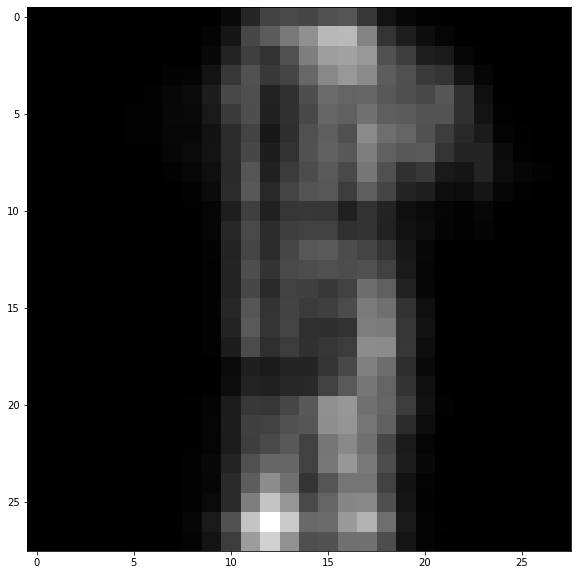

In [ ]:
generated_img = generate_sample(encoded_space = [-12,-25,10,-5,31,60,7,8,9,10], device = device)
plot_generated_sample(generated_img)

## Denoising Autoencoder

### Before training with noisy images

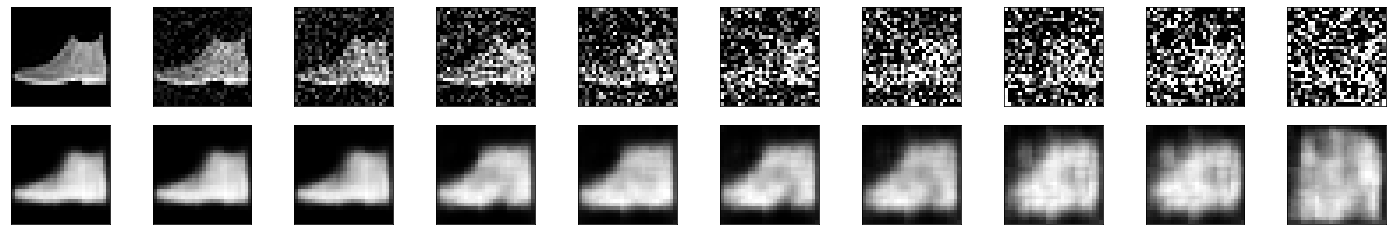

In [ ]:
def reconstruct_images(noisy_images, encoder, decoder):
  reconstructed_imgs = []
  for i in range(len(noisy_images)):
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
          image_batch = noisy_images[i].to(device)
          encoded_data = encoder(image_batch)
          decoded_data = decoder(encoded_data)
          reconstructed_imgs.append(decoded_data.cpu())

          
  # plot the corrupted input image and then reconstructed images
  fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))
  for noisy_images, row in zip([noisy_images, reconstructed_imgs], axes):
      for img, ax in zip(noisy_images, row):
          
          ax.imshow(img.squeeze().cpu().numpy(), cmap='gray')
          ax.get_xaxis().set_visible(False)
          ax.get_yaxis().set_visible(False)

def get_noisy_images(number_of_images = 10):
  noisy_images = []
  for i in range(number_of_images):
      imgc = data['test_dataset'][0][0][0].unsqueeze(0)
      noisy_image = gaussian_noise(imgc, 0.1 * i)
      noisy_images.append(noisy_image)
  return noisy_images

noisy_images = get_noisy_images()
reconstruct_images(noisy_images, data['encoder'], data['decoder'])


### Training with noisy images

	 TRAIN - EPOCH 1/50 - loss: 0.042200
	 VALIDATION - EPOCH 1/50 - loss: 0.034853


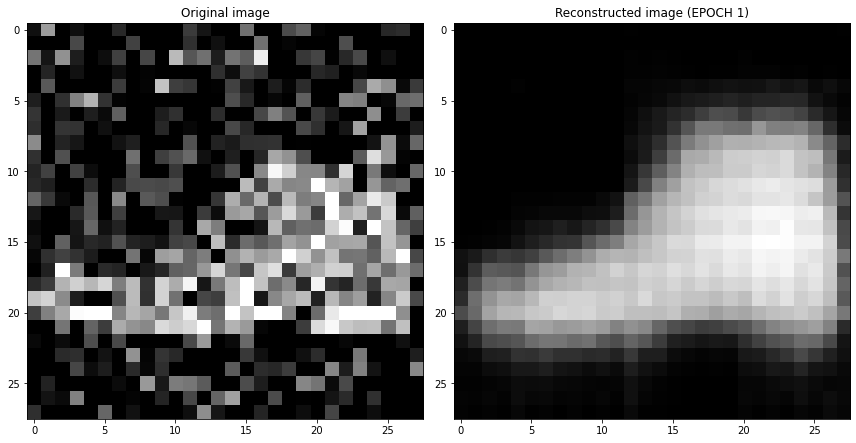

	 TRAIN - EPOCH 2/50 - loss: 0.033102
	 VALIDATION - EPOCH 2/50 - loss: 0.028596


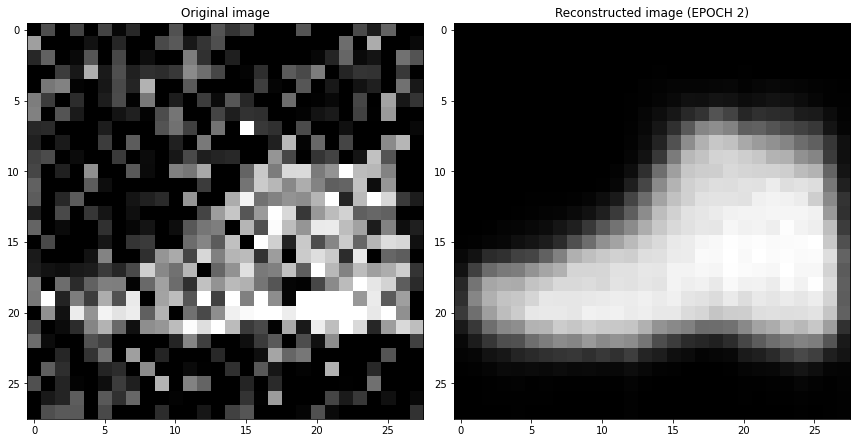

	 TRAIN - EPOCH 3/50 - loss: 0.032592
	 VALIDATION - EPOCH 3/50 - loss: 0.026774


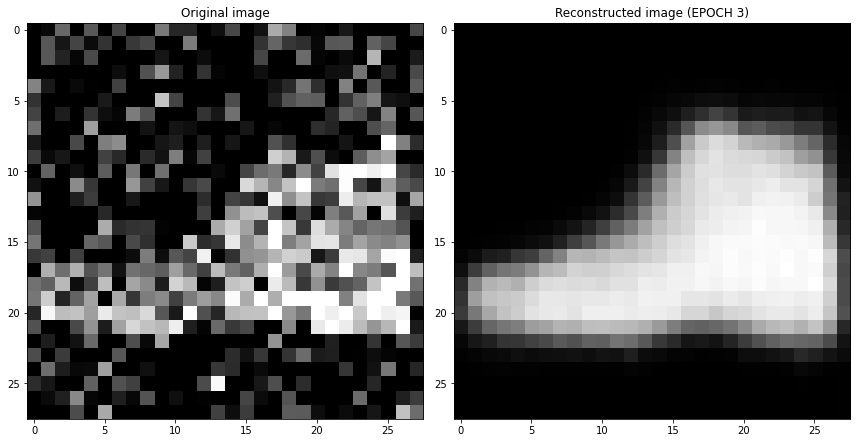

	 TRAIN - EPOCH 4/50 - loss: 0.030342
	 VALIDATION - EPOCH 4/50 - loss: 0.025693


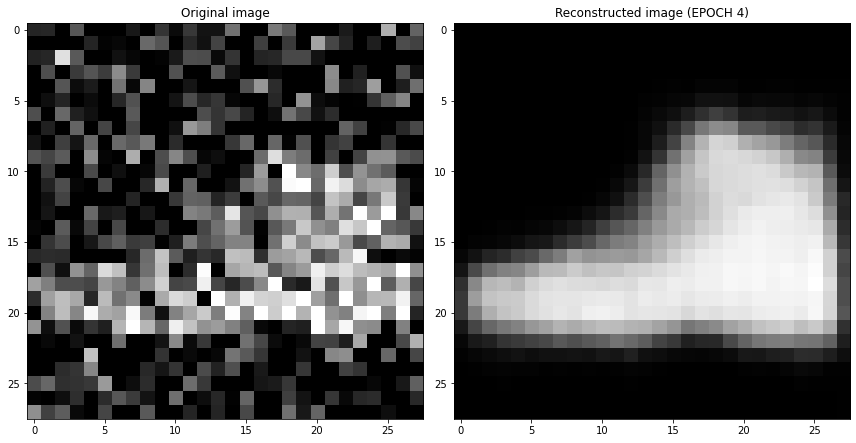

	 TRAIN - EPOCH 5/50 - loss: 0.029975
	 VALIDATION - EPOCH 5/50 - loss: 0.025088


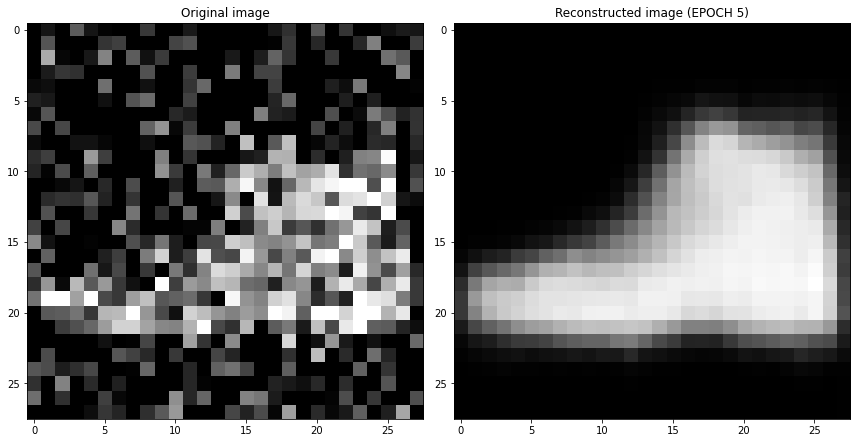

	 TRAIN - EPOCH 6/50 - loss: 0.027691
	 VALIDATION - EPOCH 6/50 - loss: 0.024660


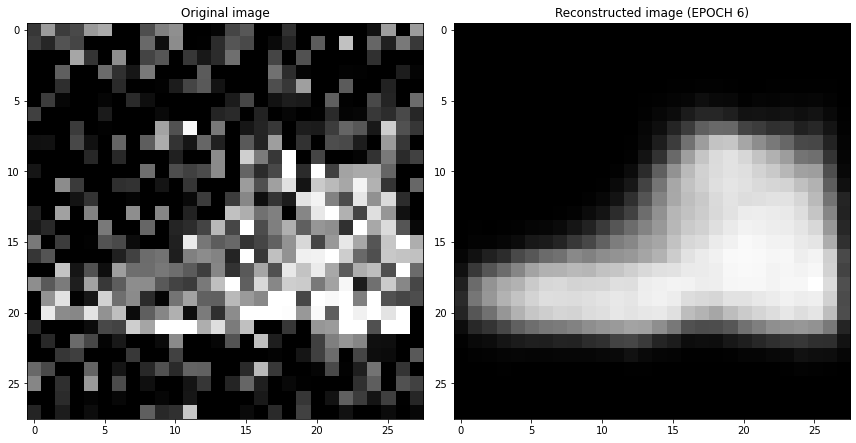

	 TRAIN - EPOCH 7/50 - loss: 0.033529
	 VALIDATION - EPOCH 7/50 - loss: 0.024104


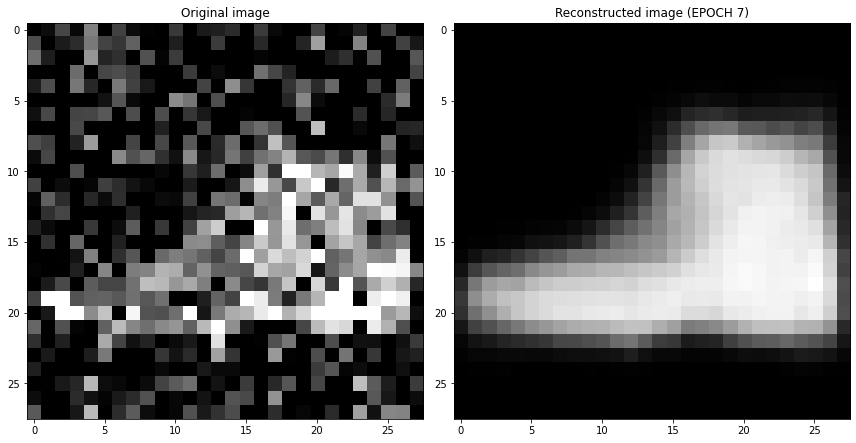

	 TRAIN - EPOCH 8/50 - loss: 0.029819
	 VALIDATION - EPOCH 8/50 - loss: 0.023653


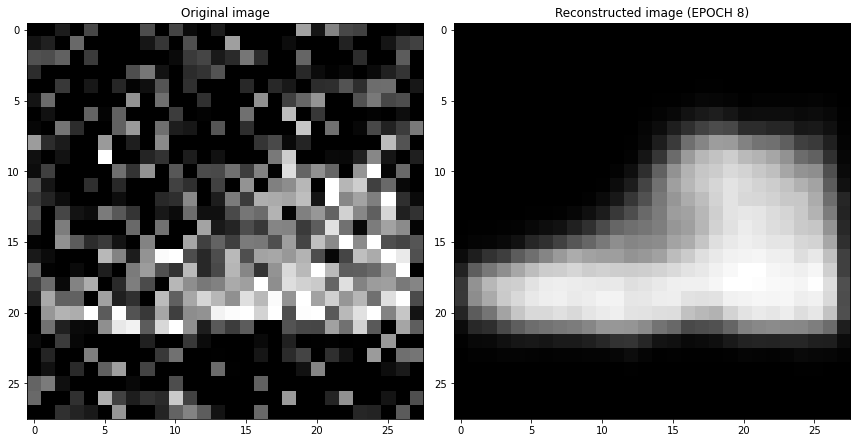

	 TRAIN - EPOCH 9/50 - loss: 0.029388
	 VALIDATION - EPOCH 9/50 - loss: 0.023346


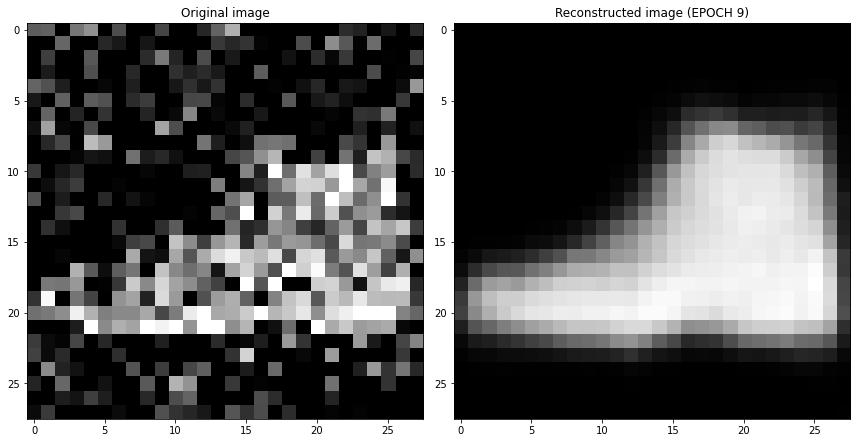

	 TRAIN - EPOCH 10/50 - loss: 0.030395
	 VALIDATION - EPOCH 10/50 - loss: 0.022870


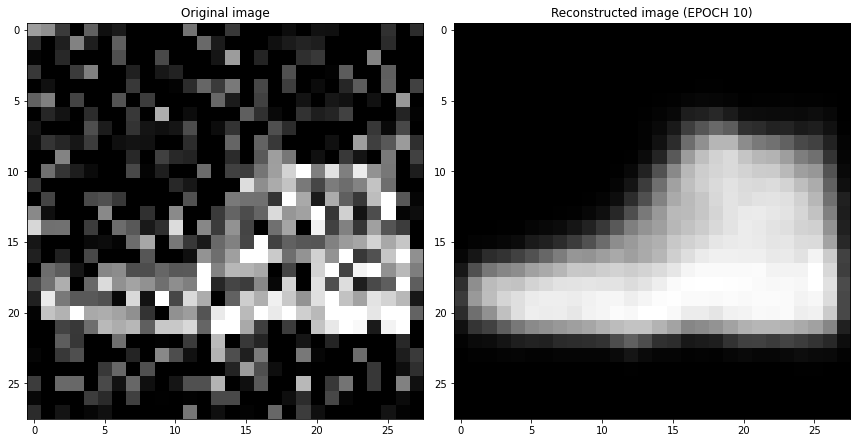

	 TRAIN - EPOCH 11/50 - loss: 0.029022
	 VALIDATION - EPOCH 11/50 - loss: 0.022766


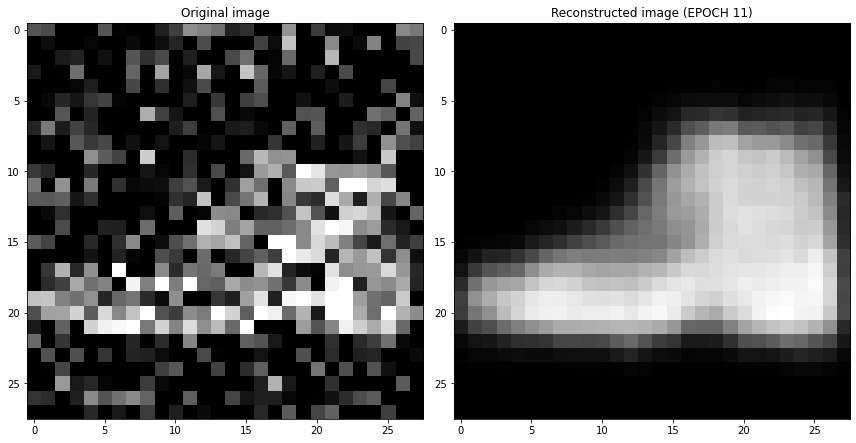

	 TRAIN - EPOCH 12/50 - loss: 0.029194
	 VALIDATION - EPOCH 12/50 - loss: 0.022507


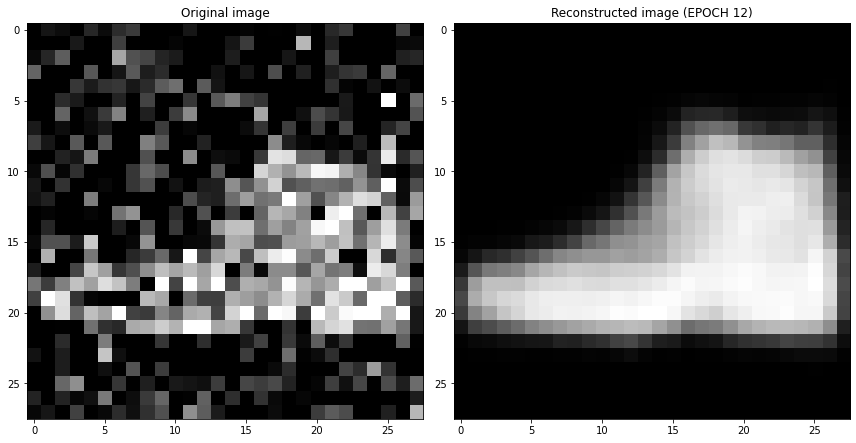

	 TRAIN - EPOCH 13/50 - loss: 0.025173
	 VALIDATION - EPOCH 13/50 - loss: 0.022180


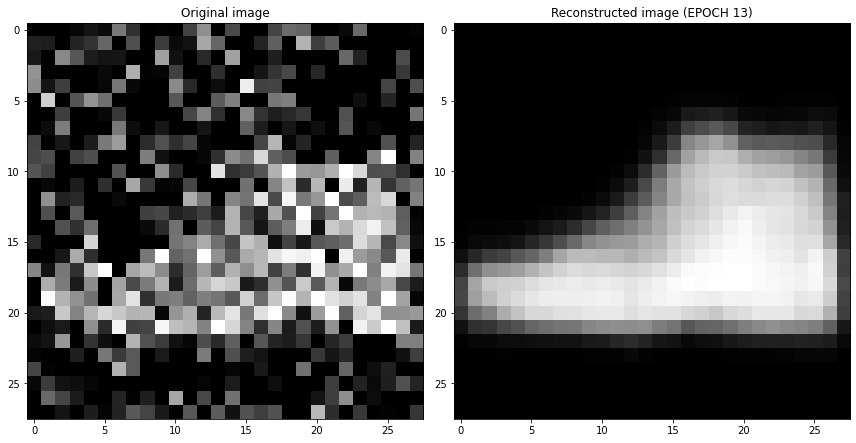

	 TRAIN - EPOCH 14/50 - loss: 0.028085
	 VALIDATION - EPOCH 14/50 - loss: 0.022020


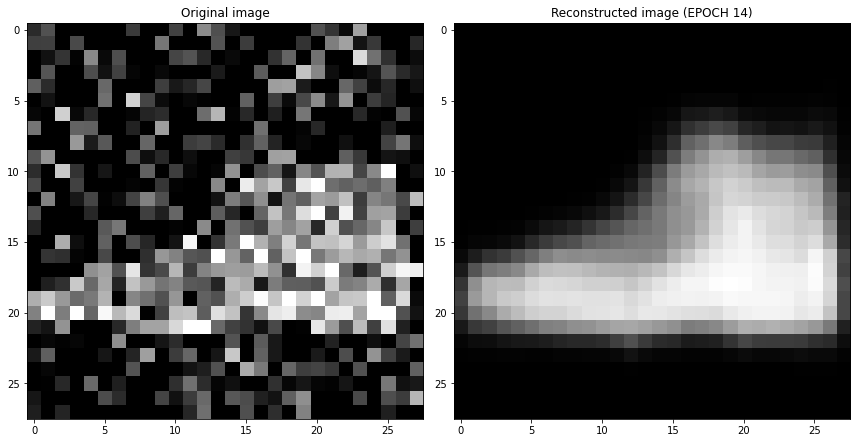

	 TRAIN - EPOCH 15/50 - loss: 0.025945
	 VALIDATION - EPOCH 15/50 - loss: 0.021897


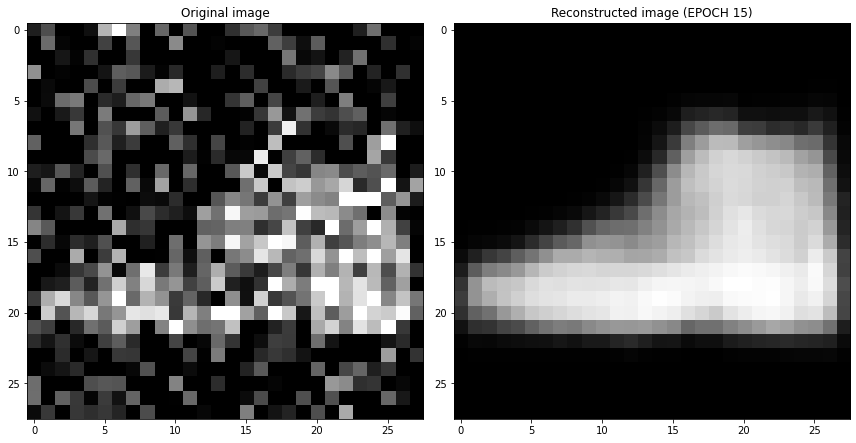

	 TRAIN - EPOCH 16/50 - loss: 0.027889
	 VALIDATION - EPOCH 16/50 - loss: 0.021913


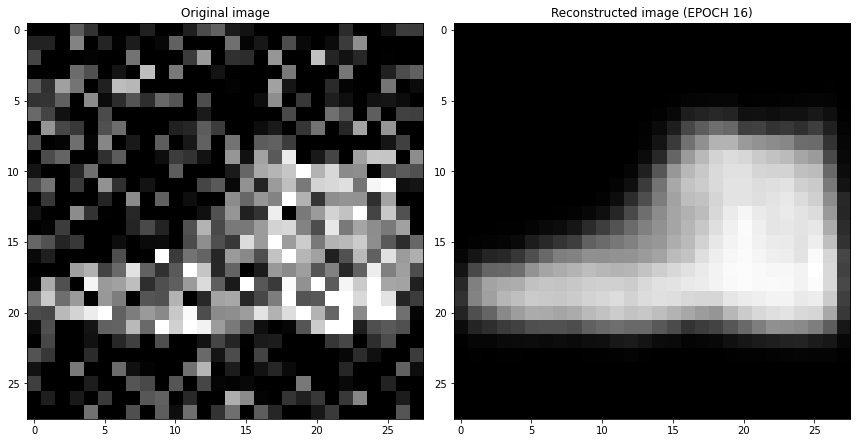

	 TRAIN - EPOCH 17/50 - loss: 0.026839
	 VALIDATION - EPOCH 17/50 - loss: 0.021740


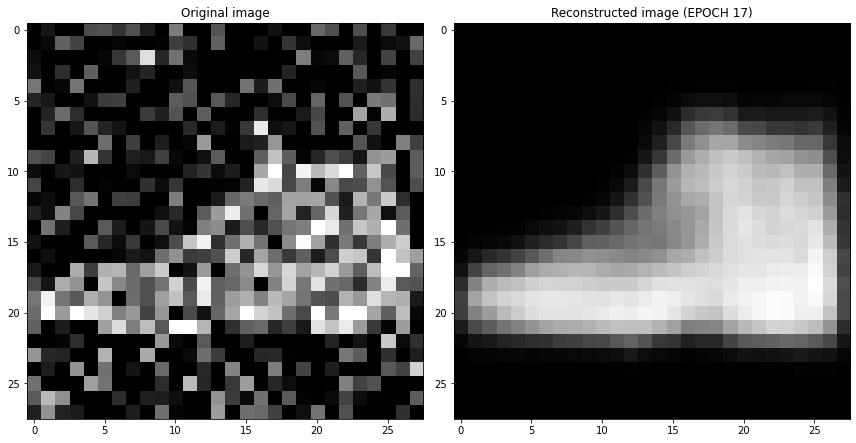

	 TRAIN - EPOCH 18/50 - loss: 0.026961
	 VALIDATION - EPOCH 18/50 - loss: 0.021578


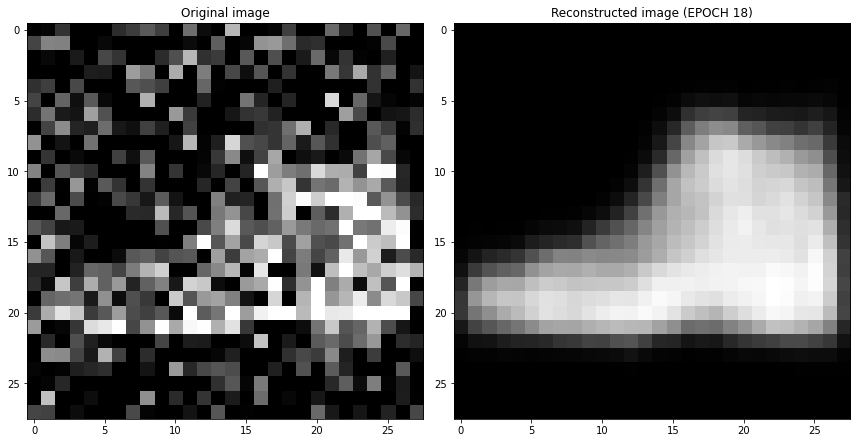

	 TRAIN - EPOCH 19/50 - loss: 0.026799
	 VALIDATION - EPOCH 19/50 - loss: 0.021410


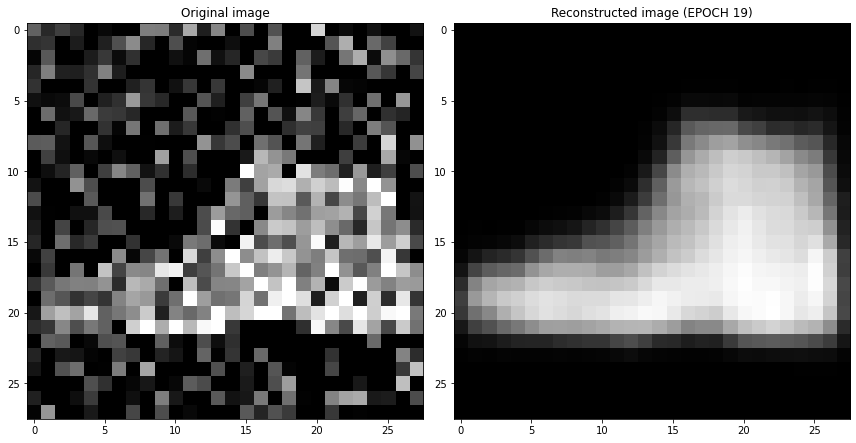

	 TRAIN - EPOCH 20/50 - loss: 0.027760
	 VALIDATION - EPOCH 20/50 - loss: 0.021664


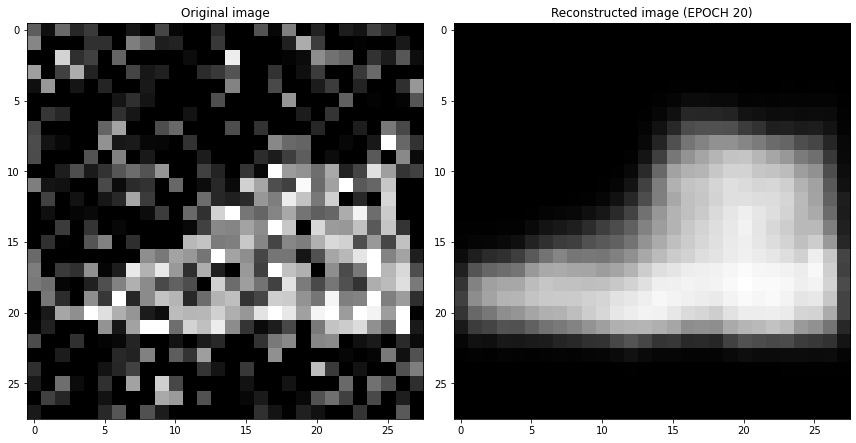

	 TRAIN - EPOCH 21/50 - loss: 0.026778
	 VALIDATION - EPOCH 21/50 - loss: 0.021529


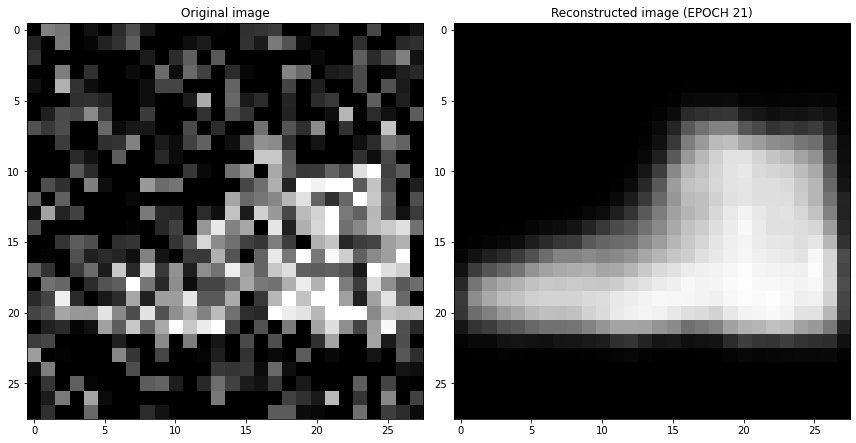

	 TRAIN - EPOCH 22/50 - loss: 0.025613
	 VALIDATION - EPOCH 22/50 - loss: 0.021229


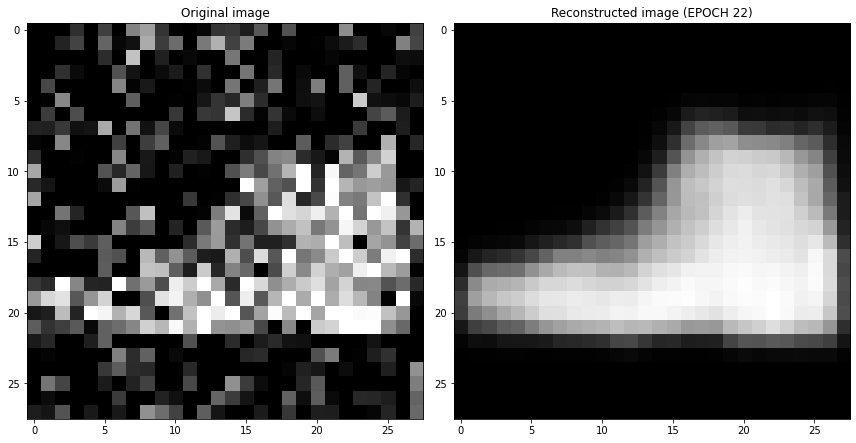

	 TRAIN - EPOCH 23/50 - loss: 0.027355
	 VALIDATION - EPOCH 23/50 - loss: 0.021486


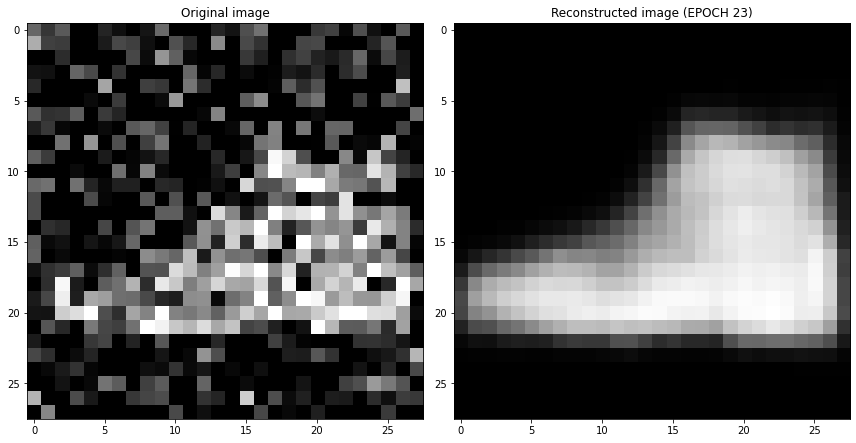

	 TRAIN - EPOCH 24/50 - loss: 0.024900
	 VALIDATION - EPOCH 24/50 - loss: 0.021213


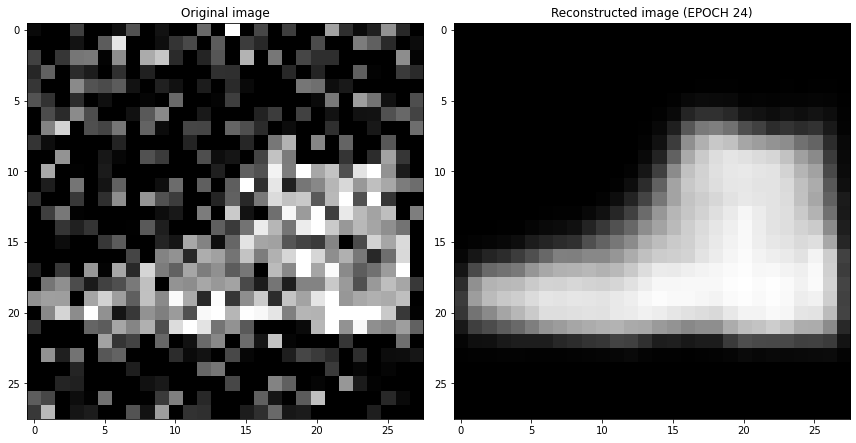

	 TRAIN - EPOCH 25/50 - loss: 0.025873
	 VALIDATION - EPOCH 25/50 - loss: 0.021512


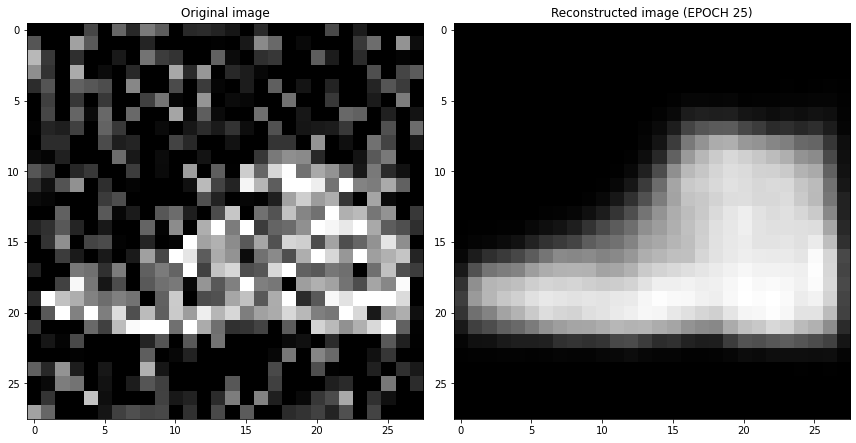

	 TRAIN - EPOCH 26/50 - loss: 0.025956
	 VALIDATION - EPOCH 26/50 - loss: 0.021198


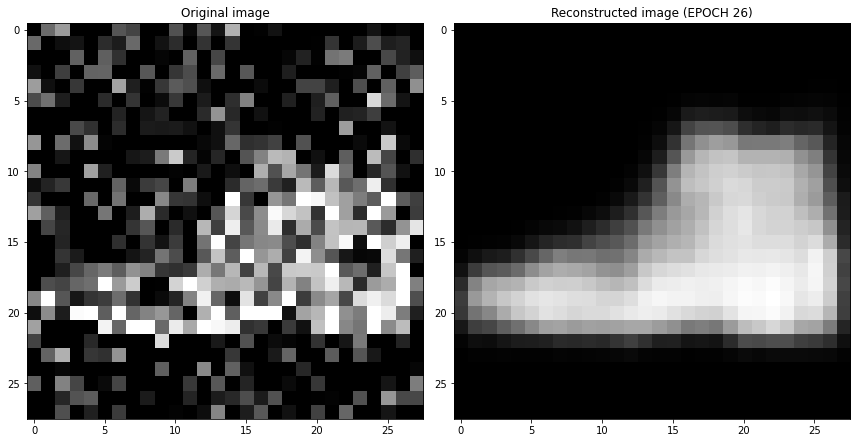

	 TRAIN - EPOCH 27/50 - loss: 0.028206
	 VALIDATION - EPOCH 27/50 - loss: 0.020939


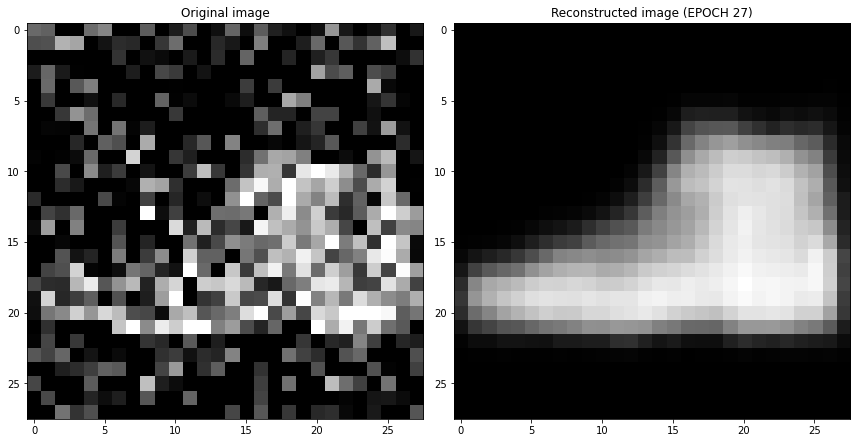

STOPPED BY EARLY STOPPING - No improvements after 8 epochs.


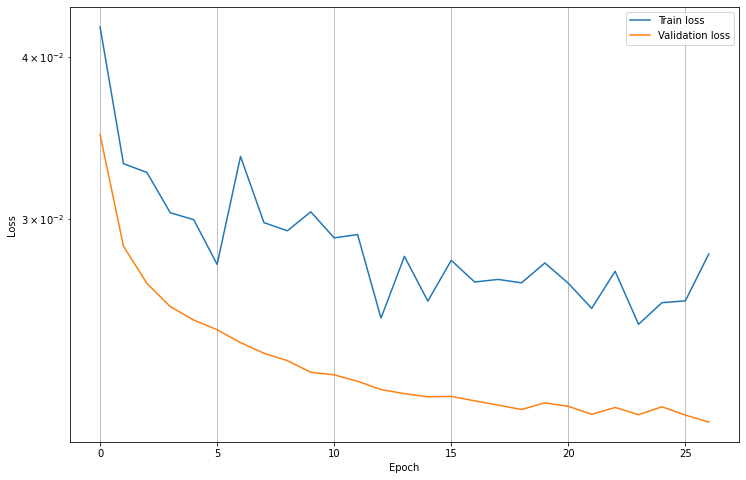

In [ ]:
train_loss_log, val_loss_log, encoder, decoder = single_train(data, list(data['best_params'].values()), plotAndSaveImages = True, should_apply_noise = True)
if torch.cuda.is_available():
  train_loss_log = [x.cpu() for x in train_loss_log]
  val_loss_log = [x.cpu() for x in val_loss_log]
plot_loss(train_loss_log, val_loss_log)
data['train_loss_log'] = train_loss_log
data['val_loss_log'] = val_loss_log
data['encoder'] = encoder
data['decoder'] = decoder

### After training with noisy images

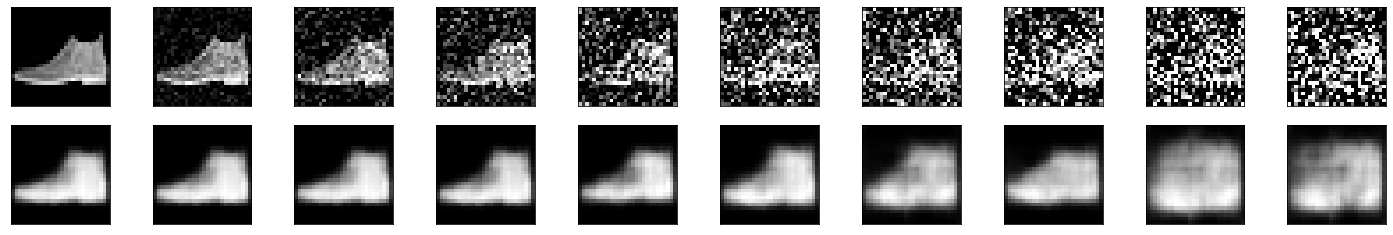

In [ ]:
noisy_images = get_noisy_images()
reconstruct_images(noisy_images, data['encoder'], data['decoder'])

# Supervised Classification

In [38]:
def split_dataset(data):
  split = int(len(data['train_dataset']) * 0.2)
  supervised_train_dataset, supervised_val_dataset = torch.utils.data.random_split(data['train_dataset'], [len(data['train_dataset'])-split, split])

  print('Samples in training set:',len(supervised_train_dataset))
  print('Samples in validation set:',len(supervised_val_dataset))

  supervised_train_dataset.transform = data['train_transform']
  supervised_val_dataset.transform = data['train_transform']

  data['supervised_train_dataset'] = supervised_train_dataset
  data['supervised_val_dataset'] = supervised_val_dataset
  data['supervised_train_dataloader'] = DataLoader(supervised_train_dataset, batch_size=256, shuffle=True)
  data['supervised_val_dataloader'] = DataLoader(supervised_val_dataset, batch_size=len(supervised_val_dataset), shuffle=False)

def config_encoder(data, device, lr = 1e-3):
  encoder = data['encoder']
  class_layer = nn.Linear(data['best_params']['encoded_space_dim'], 10)
  for param_name, param in encoder.named_parameters():
      param.requires_grad = False # disabling grad for all layers
      
  for param in encoder.encoder_lin[2].parameters():
      param.requires_grad = True

  for param in encoder.encoder_lin[0].parameters():
      param.requires_grad = True

  class_layer.to(device)
  supervised_loss = nn.CrossEntropyLoss()
  params_to_optimize = [
          {'params': encoder.parameters()},
          {'params': class_layer.parameters()}
      ]

  supervised_optimizer = torch.optim.Adam(params_to_optimize, lr=lr)

  data['class_layer'] = class_layer
  data['supervised_optimizer'] = supervised_optimizer
  data['supervised_loss'] = supervised_loss

def supervised_training(encoder, data, acc_t, train_loss):
  layer = data['class_layer']
  encoder.train()
  layer.train()
  for sample_batched in data['supervised_train_dataloader']:
      # Move data to device
      x_batch = sample_batched[0][0].to(device)
      label_batch = sample_batched[1].to(device)

      # Forward pass
      x = encoder(x_batch)
      out = layer(x)
      
      # Compute loss
      loss = data['supervised_loss'](out, label_batch)

      # Backpropagation
      encoder.zero_grad()
      layer.zero_grad()
      loss.backward()

      # Update the weights
      data['supervised_optimizer'].step()

      # Save train loss for this batch
      loss_batch = loss.detach().cpu().numpy()
      train_loss.append(loss_batch)

      #get the accuracy for this batch
      pred = np.argmax(out.detach().cpu().numpy(), axis = 1)
      right = np.sum(pred == np.array(label_batch.cpu()))
      acc_t.append(right)

def supervised_validation(encoder, data, acc_v, val_loss):
  layer = data['class_layer']
  encoder.eval()
  layer.eval()
  with torch.no_grad(): # Disable gradient tracking
    for sample_batched in data['supervised_val_dataloader']:
      # Move data to device
      x_batch = sample_batched[0][0].to(device)
      label_batch = sample_batched[1].to(device)

      # Forward pass
      x = encoder(x_batch)
      out = layer(x)

      # Compute loss
      loss = data['supervised_loss'](out, label_batch)

      # Save val loss for this batch
      loss_batch = loss.detach().cpu().numpy()
      val_loss.append(loss_batch)

      #get the accuracy for the val
      pred = np.argmax(out.detach().cpu().numpy(), axis = 1)
      right = np.sum(pred == np.array(label_batch.cpu()))
      acc_v.append(right)

def supervised_training_loop(data):
  ### TRAINING LOOP
  num_epochs = 20
  acc_train = 0
  acc_val = 0
  train_loss_log = []
  val_loss_log = []
  for epoch_num in range(num_epochs):
      ### TRAIN
      acc_t = []
      acc_v = []
      train_loss= []
      val_loss= []
      # Training mode 
      supervised_training(encoder, data, acc_t, train_loss)

      # Save average train loss
      train_loss = np.mean(train_loss)
      train_loss_log.append(train_loss)

      ### VALIDATION
      # Evaluation mode (e.g. disable dropout)
      supervised_validation(encoder, data, acc_v, val_loss)

      # Save average validation loss
      val_loss = np.mean(val_loss)
      val_loss_log.append(val_loss)

      acc_train = np.sum(acc_t)/len(data['supervised_train_dataset'])
      acc_val = np.sum(acc_v)/len(data['supervised_val_dataset'])
      print("Epoch", epoch_num + 1, "= Average train loss:[", train_loss, "] ","Accuracy train:[", np.round(acc_train,5),"] " ,"Average validation loss: [", val_loss, "]", "Accuracy validation:[",  np.round(acc_val,5),"]")
  print("\n")
  data['acc_train'] = acc_train
  data['acc_val'] = acc_val

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
						  save_path='models/'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), size=11,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)
    plt.savefig(save_path+"_picConfMatrix.png", dpi=400)
    plt.tight_layout()

def supervised_test(data):
  test_loss = []
  acc = 0

  y_test=[]
  y_pred=[]
  #move the input to the GPU and predict the output
  data['encoder'].eval()
  data['class_layer'].eval()
  with torch.no_grad(): # No need to track the gradients
      # Define the lists to store the outputs for each batch
      conc_out = []
      conc_label = []
      for sample_batched in data['test_dataloader']:
          x_batch = sample_batched[0][0].to(device)
          y = sample_batched[1].to(device)
          x = data['encoder'](x_batch) # encoding data
          out = data['class_layer'](x)

          y_test.append(y)
          y_pred.append(out)

          # Append the network output and the original image to the lists
          loss = data['supervised_loss'](out, y)
          test_loss.append(loss.detach().cpu().numpy())

          pred = np.argmax(out.detach().cpu().numpy(), axis = 1)
          right = np.sum(pred == np.array(y.cpu()))
          acc = acc + right

      test_loss = np.mean(test_loss) # Evaluate global loss

  print("Test loss MODEL:[", float(test_loss),"]", " Accuracy of MODEL:[", np.round(acc/len(data['test_dataset']),5),"]")
  return acc, pred, y


In [ ]:
split_dataset(data)
config_encoder(data, device)

Samples in training set: 48000
Samples in validation set: 12000


Epoch 1 = Average train loss:[ 1.6167808 ]  Accuracy train:[ 0.47644 ]  Average validation loss: [ 0.88733214 ] Accuracy validation:[ 0.70017 ]
Epoch 2 = Average train loss:[ 0.86096954 ]  Accuracy train:[ 0.68825 ]  Average validation loss: [ 0.67145306 ] Accuracy validation:[ 0.75342 ]
Epoch 3 = Average train loss:[ 0.7281259 ]  Accuracy train:[ 0.72854 ]  Average validation loss: [ 0.61916506 ] Accuracy validation:[ 0.76342 ]
Epoch 4 = Average train loss:[ 0.67647666 ]  Accuracy train:[ 0.74621 ]  Average validation loss: [ 0.5900467 ] Accuracy validation:[ 0.777 ]
Epoch 5 = Average train loss:[ 0.6433796 ]  Accuracy train:[ 0.75744 ]  Average validation loss: [ 0.56506723 ] Accuracy validation:[ 0.78508 ]
Epoch 6 = Average train loss:[ 0.6254123 ]  Accuracy train:[ 0.76717 ]  Average validation loss: [ 0.55455047 ] Accuracy validation:[ 0.7925 ]
Epoch 7 = Average train loss:[ 0.6081282 ]  Accuracy train:[ 0.77248 ]  Average validation loss: [ 0.54058844 ] Accuracy validation:[ 0.79

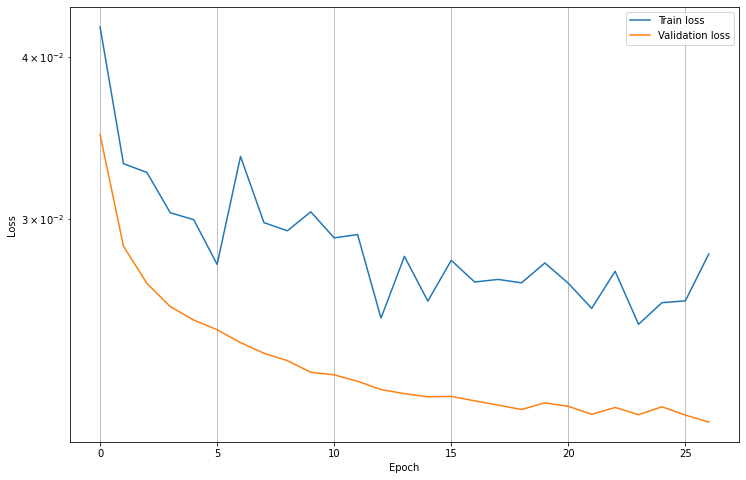

In [ ]:
supervised_training_loop(data)
if torch.cuda.is_available():
  train_loss_log = [x.cpu() for x in train_loss_log]
  val_loss_log = [x.cpu() for x in val_loss_log]
plot_loss(train_loss_log, val_loss_log)

In [39]:
acc, pred, y = supervised_test(data)

Test loss MODEL:[ 0.484470397233963 ]  Accuracy of MODEL:[ 0.8161 ]


Train Loss:	 0.028
Val Loss:	 0.021
Test Loss:	 0.021
Train Accuracy:	 0.805
Val Accuracy:	 0.827
Test Accuracy:	 0.816


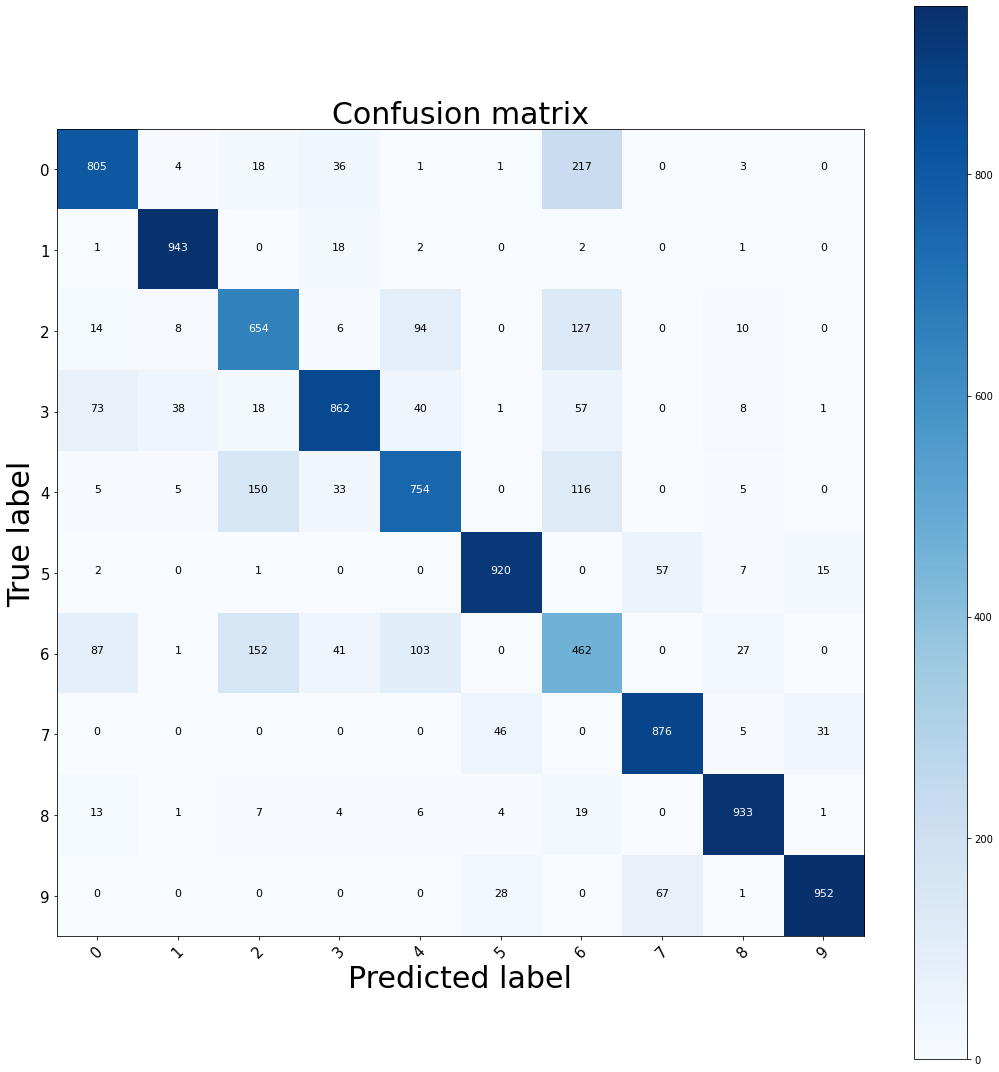

In [40]:
train_loss=train_loss_log[-1]
val_loss=val_loss_log[-1]
print("Train Loss:\t",round(float(train_loss),3))
print("Val Loss:\t",round(float(val_loss),3))
print("Test Loss:\t",round(float(test_loss),3))
print("Train Accuracy:\t",round(float(data['acc_train']),3))
print("Val Accuracy:\t",round(float(data['acc_val']),3))
print("Test Accuracy:\t",round(float(acc/len(data['test_dataset'])),3))

cm = confusion_matrix(pred, y.cpu())
categories=[0,1,2,3,4,5,6,7,8,9]
plot_confusion_matrix(cm,categories, normalize=False,save_path="conf")

# Variational Autoencoder

In [41]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

def train_vae(epoch, data):
    dataloader = data['train_dataloader']
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(dataloader):
        data = data[0].cuda() if torch.cuda.is_available() else data[0]
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(dataloader.dataset),
                100. * batch_idx / len(dataloader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(dataloader.dataset)))

def test_vae(data):
    dataloader = data['test_dataloader']
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in dataloader:
            data = data[0].cuda() if torch.cuda.is_available() else data[0]
            recon, mu, log_var = vae(data)
            
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(dataloader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

def plot_vae_samples():
  fig, axs = plt.subplots(5, 5, figsize=(8,8))
  for ax in axs.flatten():
      with torch.no_grad():
          z = torch.randn(1, 2)
          z = z.cuda() if torch.cuda.is_available() else z
          sample = vae.decoder(z)
          sample = sample.cuda() if torch.cuda.is_available() else sample
      sample=sample.view(1, 1, 28, 28)[0].cpu().squeeze().numpy()
      
      ax.imshow(sample, cmap='gray')
      ax.set_xticks([])
      ax.set_yticks([])
  plt.tight_layout()

In [42]:
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2)
if torch.cuda.is_available():
    vae.cuda()

optimizer = torch.optim.Adam(vae.parameters())

In [43]:
for epoch in range(data['params']['num_epochs']):
    train_vae(epoch, data)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning:

nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.



Train Epoch: 0 [0/60000 (0%)]	Loss: 545.426270
Train Epoch: 0 [25600/60000 (43%)]	Loss: 292.164032
Train Epoch: 0 [51200/60000 (85%)]	Loss: 276.763672
====> Epoch: 0 Average loss: 299.9001
Train Epoch: 1 [0/60000 (0%)]	Loss: 278.070038
Train Epoch: 1 [25600/60000 (43%)]	Loss: 274.664856
Train Epoch: 1 [51200/60000 (85%)]	Loss: 265.132324
====> Epoch: 1 Average loss: 270.2943
Train Epoch: 2 [0/60000 (0%)]	Loss: 271.364838
Train Epoch: 2 [25600/60000 (43%)]	Loss: 274.499115
Train Epoch: 2 [51200/60000 (85%)]	Loss: 259.709381
====> Epoch: 2 Average loss: 266.3195
Train Epoch: 3 [0/60000 (0%)]	Loss: 263.420410
Train Epoch: 3 [25600/60000 (43%)]	Loss: 260.181671
Train Epoch: 3 [51200/60000 (85%)]	Loss: 263.890411
====> Epoch: 3 Average loss: 264.1810
Train Epoch: 4 [0/60000 (0%)]	Loss: 261.229584
Train Epoch: 4 [25600/60000 (43%)]	Loss: 258.957397
Train Epoch: 4 [51200/60000 (85%)]	Loss: 261.149200
====> Epoch: 4 Average loss: 262.7911
Train Epoch: 5 [0/60000 (0%)]	Loss: 262.617432
Train Ep

In [44]:
test_vae(data)

====> Test set loss: 255.4704


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning:

nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.



/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning:

nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.



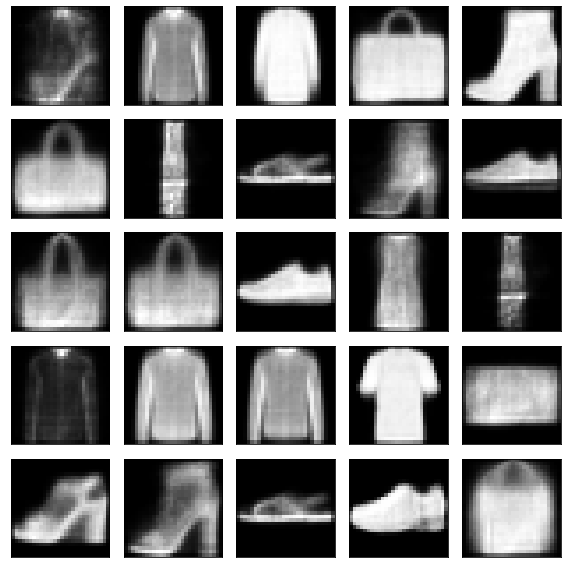

In [45]:
plot_vae_samples()

# -------------------------------------